<a href="https://colab.research.google.com/github/Stardust64/G2P_Code_Reproducibility/blob/main/G2P_Code_Reproducibility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# G2P_Code_Reproducibility

Ported to Python by Joy-El Talbot

From the R code by Kayla Barton

2020-10-14

## 1. What is a Jupyter notebook?

This is a Jupyter notebook document. Much like R Markdown files, it let's you combine exposition with your code for an easier to understand analysis summary.

The notebook uses "cells" that contain information processed in different ways. Markdown or Text cells use special code to add formatting to text. Meanwhile, the code cells are evaluated by the Python interprettor just as any python code would be. The results of these code cells are printed below the code cell.

### And what about Google Colab?

Google Colab is a new space that let's you run Jupyter-style python notebooks in the cloud. These have sharing and commenting features similar to those you may already be used to from using Google Docs or Sheets.

## 2. Analyzing count data

### a) Prepare libraries and get dataset
Load needed libraries

In [ ]:
import pandas as pd  # Provides dataframe functionality similar to R's data.frame objects
from matplotlib import pyplot as plt
from numpy import log2 as log2

### b) Read in counts file from github!
If you want to do this with your own files on github make sure to get the url from the raw file. (click 'view raw' on desired file in github, the url should say https://raw.github instead of https://github)


In [ ]:
raw_count_data = pd.read_csv("https://raw.githubusercontent.com/Stardust64/G2P_Code_Reproducibility/main/counts_all_samples.csv")

### c) Check and fix matrix

Check column labels to make sure they are correct, then check first row to make sure it looks okay. (There should be 17 columns in total: V1, alb_dex_rep1_511_counts, alb_dex_rep2_515_counts, alb_dex_rep3_519_counts, alb_dex_rep4_523_counts, alb_rep1_510_counts, alb_rep2_514_counts, alb_rep3_518_counts, alb_rep4_522_counts, dex_rep1_509_counts, dex_rep2_513_counts, dex_rep3_517_counts, dex_rep4_521_counts, untreated_rep1_508_counts, untreated_rep2_512_counts, untreated_rep3_516_counts, and untreated_rep4_520_counts) 

In [ ]:
# check the column names & their data types
print(raw_count_data.dtypes)

# view a sample of the data
raw_count_data.head()

V1                           object
alb_dex_rep1_511_counts       int64
alb_dex_rep2_515_counts       int64
alb_dex_rep3_519_counts       int64
alb_dex_rep4_523_counts       int64
alb_rep1_510_counts           int64
alb_rep2_514_counts           int64
alb_rep3_518_counts           int64
alb_rep4_522_counts           int64
dex_rep1_509_counts           int64
dex_rep2_513_counts           int64
dex_rep3_517_counts           int64
dex_rep4_521_counts           int64
untreated_rep1_508_counts     int64
untreated_rep2_512_counts     int64
untreated_rep3_516_counts     int64
untreated_rep4_520_counts     int64
dtype: object


,V1,alb_dex_rep1_511_counts,alb_dex_rep2_515_counts,alb_dex_rep3_519_counts,alb_dex_rep4_523_counts,alb_rep1_510_counts,alb_rep2_514_counts,alb_rep3_518_counts,alb_rep4_522_counts,dex_rep1_509_counts,dex_rep2_513_counts,dex_rep3_517_counts,dex_rep4_521_counts,untreated_rep1_508_counts,untreated_rep2_512_counts,untreated_rep3_516_counts,untreated_rep4_520_counts
0,ENSG00000000003,916,1725,2237,1686,1486,1948,2178,2225,914,819,2074,1165,1379,1755,2305,1563
1,ENSG00000000005,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
2,ENSG00000000419,1001,823,911,1223,874,1568,1295,959,981,657,1413,907,889,1116,1035,754
3,ENSG00000000457,449,433,402,550,459,664,569,508,417,327,662,449,505,537,493,464
4,ENSG00000000460,113,98,127,173,174,177,135,158,103,64,124,121,122,82,148,139


Construct a new matrix so that geneIDs are used as row labels (aka index), then check row again to see if it worked. 

In [ ]:
count_data = raw_count_data.rename(columns={"V1":"geneIDs"})
count_data.set_index("geneIDs", inplace=True)  # must add "inplace=True" argument to overwrite existing count_data
count_data.head()

,alb_dex_rep1_511_counts,alb_dex_rep2_515_counts,alb_dex_rep3_519_counts,alb_dex_rep4_523_counts,alb_rep1_510_counts,alb_rep2_514_counts,alb_rep3_518_counts,alb_rep4_522_counts,dex_rep1_509_counts,dex_rep2_513_counts,dex_rep3_517_counts,dex_rep4_521_counts,untreated_rep1_508_counts,untreated_rep2_512_counts,untreated_rep3_516_counts,untreated_rep4_520_counts
geneIDs,,,,,,,,,,,,,,,,
ENSG00000000003,916,1725,2237,1686,1486,1948,2178,2225,914,819,2074,1165,1379,1755,2305,1563
ENSG00000000005,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
ENSG00000000419,1001,823,911,1223,874,1568,1295,959,981,657,1413,907,889,1116,1035,754
ENSG00000000457,449,433,402,550,459,664,569,508,417,327,662,449,505,537,493,464
ENSG00000000460,113,98,127,173,174,177,135,158,103,64,124,121,122,82,148,139


### d) Boxplot of counts

Now let's make a Boxplot! (Added 1 to all filtered counts to avoid log2(0))


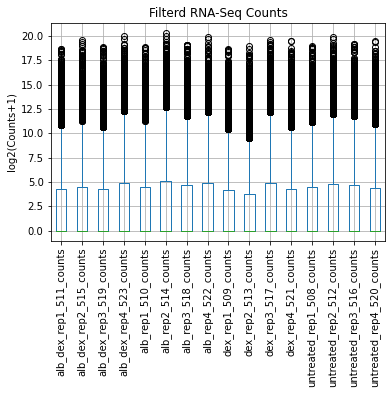

In [ ]:
df_plot = log2(count_data + 1)
df_plot.boxplot()
plt.title("Filterd RNA-Seq Counts")
plt.ylabel("log2(Counts+1)")
plt.xticks(rotation=90)
plt.show()  # in base-python script, forces plot to show; here it hides additional behind-the-scenes text

Whats wrong with this boxplot? 


Lets clean it up a bit by filtering out lowly expressed genes!  

### e) Make DGEList and Filter out Lowly Expressed Genes

Create Differential Gene Expression (DGE) List using filtered counts. 

While Python does not have the EdgeR library, depending on what you want to do there may be many ways to work around this. 

1. Extract your data from Python to R for the necessary steps and then return it to Python. Especially if the computations are complex, this may be the best solution and follows a general trend in computer science of using the right tool for the job. 

2. If the computations are generic, implement them in the current language. In this case we will choose this option. 

R code: `DGE <- DGEList(counts = count_data, genes = row.names(count_data))`

What it does: Stores the date in a standard format for EdgeR

How we replicate: Not needed as we won't be using EdgeR


R code: `keep <-rowSums(cpm(DGE)>=1) >=4; DGE<-DGE[keep,]`

What it does: For each gene (row): sum the values if their cpm is greater than or equal to 1, if the sum is greater than or equal to 4 then keep the geneID in the final data.

What `cpm` does: Based on [its documentation](https://www.rdocumentation.org/packages/edgeR/versions/3.14.0/topics/cpm), cpm computes counts per million. When used on a DGEList object, it also uses normalized library sizes in the computation rather than the simple column sums used when the object is a matrix. However, given that we did not provide library sizes in the DGEList constructor, the sum of the column would have been used instead (source: [DGEList documentation](https://rdrr.io/bioc/edgeR/man/DGEList.html))

How we replicate: 
  1. Get cmp equivalent: Divide the count of each cell by the total sum of its column and multiply by one million
  2. Apply the same filtering as above

In [ ]:
# create a copy of the dataframe to normalize
normalized = count_data.copy()

# loop through each column performing the normalization
for col in normalized.columns:
  normalized[col] = count_data[col] / count_data[col].sum() * 1000000

normalized.head()

# create list of geneIDs to be kept
# keeps geneIDs where at least four libraries have cpm counts above 1
keep = (normalized >= 1).sum(axis=1) >= 4

# filter normalized data
normalized = normalized[keep]

R code: `DGE <- calcNormFactors(DGE)`

What it does: Calculates normalization factors to scale the raw library sizes (Source: [calcNormFactors documentation](https://www.rdocumentation.org/packages/edgeR/versions/3.14.0/topics/calcNormFactors)) Based on [further documentation](https://www.bioconductor.org/packages/release/bioc/vignettes/edgeR/inst/doc/edgeRUsersGuide.pdf) the TMM method is used by default. 

"method="TMM" is the weighted trimmed mean of M-values (to the reference) proposed by Robinson and Oshlack (2010), where the weights are from the delta method on Binomial data. If refColumn is unspecified, the library whose upper quartile is closest to the mean upper quartile is used." - [calcNormFactors documentation](https://www.rdocumentation.org/packages/edgeR/versions/3.14.0/topics/calcNormFactors)

How we replicate: We would want to review the sited paper and replicate the calcuations. 

However - for brevity, we will keep the base normalization for now. :-)


### f) Boxplot of counts After Filtering Lowly Expressed Genes

Create new boxplot with cleaned dataset!

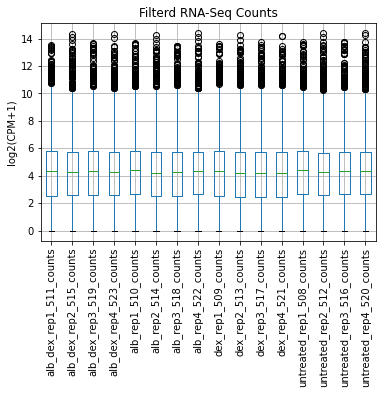

In [ ]:
df_plot = log2(normalized + 1)
df_plot.boxplot()
plt.title("Filterd RNA-Seq Counts")
plt.ylabel("log2(CPM+1)")
plt.xticks(rotation=90)
plt.show()  # in base-python script, forces plot to show; here it hides additional behind-the-scenes text

This looks much better! Now lets pretend that this is the figure we want to help someone recreate in Colab. 

With Colab, you can make a copy of this notebook and change the datasource above to re-run with your own datasource!
